In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time
os.environ['TZ'] ='America/New_York'

import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

from ib_async import *
util.startLoop()

### Data Prep for Inferencing

In [3]:
ib = IB()
ib.connect(port=4001, clientId=9)

<IB connected to 127.0.0.1:4001 clientId=9>

In [4]:
contract = Contract(symbol='META', secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

[Contract(secType='STK', conId=107113386, symbol='META', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='META', tradingClass='NMS')]

In [5]:
contract_vix = Contract(symbol= 'VIX', secType = 'IND',exchange = 'CBOE', currency='USD')
ib.qualifyContracts(contract_vix)

[Contract(secType='IND', conId=13455763, symbol='VIX', exchange='CBOE', currency='USD', localSymbol='VIX')]

In [6]:
contract_nas = Contract(symbol= 'TQQQ', secType = 'STK',exchange = 'SMART', currency='USD')
ib.qualifyContracts(contract_nas)

[Contract(secType='STK', conId=72539702, symbol='TQQQ', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='TQQQ', tradingClass='NMS')]

In [54]:
class Data_Request :

    """
    Returns PD data containning equity price with specific time control

    Returns:
        pd: information regarding the contract of interst.
    """
    
    def __init__(self, list_days, contract, barsize, duration, *,specific_time= None, specific_pick_time= None):

        self.list_days = list_days
        self.contract = contract
        #self.init_date = init_date
        self.barsize = barsize
        self.duration = duration
        self.specific_time = specific_time # cut off time . Time object: time(14, 30, 0)
        self.specific_pick_time= specific_pick_time

    def D_request(self):

        his_df =pd.DataFrame()
        
        for i in range(len(self.list_days)):
            init_date=self.list_days[i]
            bars = ib.reqHistoricalData(self.contract, init_date, barSizeSetting=self.barsize, durationStr=self.duration, whatToShow="TRADES", useRTH=True)
            add_his_df = pd.DataFrame(bars)
            add_his_df['date'] = pd.to_datetime(add_his_df['date'])
            print(f'retriveing data for {init_date}')

            if self.specific_time is not None:
                cut_off = datetime.combine(self.list_days[i],self.specific_time)  # need logic if specific_time is defined
                pd_cut_off = pd.to_datetime(cut_off).tz_localize('US/Eastern')
            #datetime64_eastern = pd.Timestamp(date_time_str).tz_localize('US/Eastern')
                add_his_df = add_his_df[add_his_df['date'] > pd_cut_off]
            
            if self.specific_pick_time is not None:
                pick_time = datetime.combine(self.list_days[i],self.specific_pick_time)  # need logic if specific_time is defined
                pd_pick_time = pd.to_datetime(pick_time).tz_localize('US/Eastern')
            #datetime64_eastern = pd.Timestamp(date_time_str).tz_localize('US/Eastern')
                add_his_df = add_his_df[add_his_df['date'] == pd_pick_time]

            
            his_df = pd.concat([his_df, add_his_df], ignore_index=True)
            his_df['Date_Only'] = his_df['date'].dt.date
            print(len(his_df))

        
        return his_df


In [55]:
# picking out Friday and before specific-time data

#specific_time = time(14, 30, 0)
def data_filter(df_initial, list_days, specific_time_before = None, specific_time_after= None, on_time= None):
    his_df = pd.DataFrame()
    for i in range(len(list_days)):
        init_date=list_days[i]
        if specific_time_before is not None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date) & (df_initial['date'].dt.time < specific_time_before)]
           
            
        if specific_time_after is not None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date) & (df_initial['date'].dt.time >= specific_time_after)]

        if on_time is not None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date) & (df_initial['date'].dt.time == on_time)]

        if (specific_time_before is None and specific_time_after is None) and on_time is None:
            add_his_df = df_initial[(df_initial['date'].dt.date == init_date)]
        
        print(len(his_df))
        print(f'retrieving {init_date}')
        per_proc = np.round(i+1/len(list_days)*100, decimals=1)
        print(f'{per_proc} percent is done')
        his_df = pd.concat([his_df, add_his_df], ignore_index=True)
        his_df.drop_duplicates(subset=None, keep='first', inplace=True)
        his_df['Date_Only'] = his_df['date'].dt.date
    return his_df

In [56]:
def get_fridays_in_range(start_date, end_date):
    """
    Returns a list of dates that are Fridays within the given date range.

    Args:
        start_date (date): The start date of the range.
        end_date (date): The end date of the range.

    Returns:
        list: A list of date objects representing Fridays within the range.
    """
    fridays = []
    all_dates = []
    current_date = start_date
    all_current_date = start_date

    # Adjust to the first Friday
    days_until_friday = (4 - current_date.weekday()) % 7
    current_date += timedelta(days=days_until_friday)

    while current_date <= end_date:
        fridays.append(current_date)
        current_date += timedelta(days=7) # Move to the next Friday

    while all_current_date <= end_date:
        all_dates.append(all_current_date)
        all_current_date += timedelta(days=1)
    
    return fridays, all_dates

# Example Usage
start_date = date(2024, 1, 1)
end_date = date(2025, 4, 1)

fridays, all_dates = get_fridays_in_range(start_date, end_date)
# removing Non-trading Holidays
fridays.remove(date(2024, 3, 29))
fridays.remove(date(2024, 11, 29))

In [57]:
now =datetime.now()
#print(now.date())
#print(now.time().minute)
#infer_time = time(now.time().hour, now.time().minute -15 )
#infer_time = time(now.time().hour, now.time().minute)
inferencing_date = now.date() - timedelta(1)

#to_day = datetime.now().strftime("%y%m%d")

#datetime.now() -timedelta(1)

infer_time = time(14,30,0)
#infer_time = time(14,30,0)

### Inferencing Data Set Collection ###

In [58]:
barsize ="30 secs"
duration = "1 D"
#DR_stock_meta = Data_Request( " ",contract, barsize, duration)
DR_stock_meta = Data_Request([inferencing_date], contract, barsize, duration)
df_all_days_stock = DR_stock_meta.D_request()

retriveing data for 2025-04-04
780


In [59]:
DR_IND_VIX = Data_Request([inferencing_date], contract_vix, barsize, duration)
DR_STK_TQQQ = Data_Request([inferencing_date], contract_nas, barsize, duration)
df_all_days_VIX = DR_IND_VIX.D_request()
df_all_days_TQQQ = DR_STK_TQQQ.D_request()

retriveing data for 2025-04-04
1620
retriveing data for 2025-04-04
780


In [60]:
print(df_all_days_stock.tail(1))
print(df_all_days_VIX.tail(1))
print(df_all_days_TQQQ.tail(1))

                         date    open    high     low   close    volume  \
779 2025-04-04 15:59:30-04:00  504.71  505.07  504.32  504.74  200485.0   

     average  barCount   Date_Only  
779  504.631      1289  2025-04-04  
                          date   open   high    low  close  volume  average  \
1619 2025-04-04 15:59:30-05:00  45.31  45.31  45.31  45.31     0.0      0.0   

      barCount   Date_Only  
1619         0  2025-04-04  
                         date   open   high    low  close    volume  average  \
779 2025-04-04 15:59:30-04:00  41.12  41.19  41.03  41.09  645543.0   41.089   

     barCount   Date_Only  
779      1467  2025-04-04  


In [61]:
#df_all_days_stock = DR_stock_meta.D_request()

In [62]:

def data_sparcing_construc(df, sp_day, *, cut_time = None):
    #df_group = df.groupby("Date_Only").std(numeric_only=True)
    df_filter_prior = data_filter(df, sp_day, specific_time_before = cut_time )
    df_group_prior = df_filter_prior.groupby("Date_Only").std(numeric_only=True)
    
    #df_filter_after = data_filter(df, sp_day, specific_time_after = cut_time )
    #df_group_after = df_filter_after.groupby("Date_Only").std(numeric_only=True)


    df_group_train =pd.DataFrame()
    #df_group_train['Target_std'] = pd.DataFrame(df_group_after[['open','high','low','close']].max(axis=1))
    df_group_train['prior_std'] = pd.DataFrame(df_group_prior[['open','high','low','close']].max(axis=1))
    df_group_train['prior_Vol'] = pd.DataFrame(df_filter_prior.groupby("Date_Only").mean()['volume'])
    df_group_train['prior_spread'] = df_filter_prior.groupby('Date_Only')['open'].max() - df_filter_prior.groupby('Date_Only')['open'].min()


    df_group_train['prior_range'] =pd.DataFrame(df_filter_prior.groupby('Date_Only')['close'].max() -df_filter_prior.groupby('Date_Only')['close'].min() )

    df_initial = df_filter_prior
    new_time = time(cut_time.hour, cut_time.minute -1)
    df_group_train['cut_open'] = df_initial[(df_initial['date'].dt.time == new_time)]['open'].values
    
    cut_name =['cut_1hr','cut_2hr','cut_3hr']
    for i in range(3):
        print(f'time avaiable {i}')
        prior = time(cut_time.hour - (i+1), cut_time.minute)
        df_group_train[cut_name[i]] = df_initial[(df_initial['date'].dt.time == new_time)]['open'].values- df_initial[(df_initial['date'].dt.time == prior)]['open'].values

    #df_group_train['Class_target'] = df_filter_after[(df_filter_after['date'].dt.time == time(15, 49, 0))]['close'].values- df_initial[(df_initial['date'].dt.time == new_time)]['open'].values
    
    return df_group_train, df_filter_prior, df_group_prior
    

In [63]:
#print(now.time().minute)
#infer_time = time(now.time().hour, now.time().minute -15 )
print(infer_time)

14:30:00


In [64]:
df_all_days_stock

,date,open,high,low,close,volume,average,barCount,Date_Only
0,2025-04-04 09:30:00-04:00,506.89,508.20,505.05,505.28,653171.0,506.196,1608,2025-04-04
1,2025-04-04 09:30:30-04:00,505.28,505.69,502.43,503.62,198419.0,504.138,1205,2025-04-04
2,2025-04-04 09:31:00-04:00,503.69,510.00,503.35,508.59,141298.0,507.088,755,2025-04-04
3,2025-04-04 09:31:30-04:00,508.55,510.60,508.33,510.20,65991.0,509.771,411,2025-04-04
4,2025-04-04 09:32:00-04:00,510.11,510.80,509.03,509.84,74243.0,509.947,464,2025-04-04
...,...,...,...,...,...,...,...,...,...
775,2025-04-04 15:57:30-04:00,505.49,505.49,504.54,504.76,110267.0,505.118,768,2025-04-04
776,2025-04-04 15:58:00-04:00,504.82,505.83,504.44,505.58,104134.0,504.948,637,2025-04-04
777,2025-04-04 15:58:30-04:00,505.59,505.69,504.96,505.00,97282.0,505.359,674,2025-04-04
778,2025-04-04 15:59:00-04:00,505.07,505.09,504.32,504.68,168555.0,504.581,1248,2025-04-04


In [65]:
df_group_train, df_filter_prior, df_group_prior = data_sparcing_construc(df_all_days_stock, [inferencing_date], cut_time= infer_time)

0
retrieving 2025-04-04
100.0 percent is done
time avaiable 0
time avaiable 1
time avaiable 2


In [66]:
df_group_train_tqqq, *_ = data_sparcing_construc(df_all_days_TQQQ, [inferencing_date], cut_time= infer_time)

0
retrieving 2025-04-04
100.0 percent is done
time avaiable 0
time avaiable 1
time avaiable 2


In [67]:
# end time needs to be adjusted
#vix_infer_time = time(now.time().hour -1, now.time().minute )
vix_infer_time = infer_time 

In [68]:
df_group_train_vix, *_ = data_sparcing_construc(df_all_days_VIX, [inferencing_date], cut_time= vix_infer_time)

0
retrieving 2025-04-04
100.0 percent is done
time avaiable 0
time avaiable 1
time avaiable 2


In [69]:
df_group_train_vix

,prior_std,prior_Vol,prior_spread,prior_range,cut_open,cut_1hr,cut_2hr,cut_3hr
Date_Only,,,,,,,,
2025-04-04,4.578982,0.0,15.53,15.55,42.66,-0.05,1.03,2.17


In [70]:
df_final_joninted_vix=pd.DataFrame()
df_final_joninted_all=pd.DataFrame()

df_group_train_vix.columns =['vix_prior_std','vix_Vol','vix_pr_spread','vix_prior_range','vix_cut_open','vix_cut_1hr','vix_cut_2hr','vix_cut_3hr']
df_final_jointed_vix = pd.concat([df_group_train,df_group_train_vix], axis=1)
df_group_train_tqqq.columns =['tqqq_prior_std','tqqq_Vol','tqqq_pr_spread','tqqq_prior_range','tqqq_cut_open','tqqq_cut_1hr','tqqq_cut_2hr','tqqq_cut_3hr']
df_final_jointed_all = pd.concat([df_final_jointed_vix,df_group_train_tqqq], axis=1)
df_final_jointed_all.drop(['vix_Vol'], axis=1, inplace=True)

In [71]:
df_final_jointed_all

,prior_std,prior_Vol,prior_spread,prior_range,cut_open,cut_1hr,cut_2hr,cut_3hr,vix_prior_std,vix_pr_spread,...,vix_cut_2hr,vix_cut_3hr,tqqq_prior_std,tqqq_Vol,tqqq_pr_spread,tqqq_prior_range,tqqq_cut_open,tqqq_cut_1hr,tqqq_cut_2hr,tqqq_cut_3hr
Date_Only,,,,,,,,,,,,,,,,,,,,,
2025-04-04,3.358466,29065.301667,22.6,22.77,508.59,0.45,2.54,-2.22,4.578982,15.53,...,1.03,2.17,1.173603,262086.091667,4.71,4.72,42.14,-0.37,-0.73,-2.17


### INFERENCING###

In [72]:
df_final_jointed_all.columns

Index(['prior_std', 'prior_Vol', 'prior_spread', 'prior_range', 'cut_open',
       'cut_1hr', 'cut_2hr', 'cut_3hr', 'vix_prior_std', 'vix_pr_spread',
       'vix_prior_range', 'vix_cut_open', 'vix_cut_1hr', 'vix_cut_2hr',
       'vix_cut_3hr', 'tqqq_prior_std', 'tqqq_Vol', 'tqqq_pr_spread',
       'tqqq_prior_range', 'tqqq_cut_open', 'tqqq_cut_1hr', 'tqqq_cut_2hr',
       'tqqq_cut_3hr'],
      dtype='object')

In [ ]:
Index(['Target_std', 'Target_spread', 'prior_std', 'prior_Vol', 'prior_spread',
       'prior_range', 'cut_open', 'cut_1hr', 'cut_2hr', 'cut_3hr',
       'vix_prior_std', 'vix_pr_spread', 'vix_prior_range', 'vix_cut_open',
       'vix_cut_1hr', 'vix_cut_2hr', 'vix_cut_3hr', 'tqqq_prior_std',
       'tqqq_Vol', 'tqqq_pr_spread', 'tqqq_prior_range', 'tqqq_cut_open',
       'tqqq_cut_1hr', 'tqqq_cut_2hr', 'tqqq_cut_3hr'],
      dtype='object')

In [73]:
df_final_jointed_all.reset_index(inplace=True)
inference_data = df_final_jointed_all.drop('Date_Only', axis=1)

In [74]:
inference_data.shape

(1, 23)

### spread model

In [84]:

entry = df_all_days_stock.tail(1)['close'].values

In [75]:
import joblib
# Assuming 'model' is your trained model object
# spread_model
filename = 'xgb_model_w_all_spread.joblib'
loaded_model = joblib.load(filename)

In [95]:
filename_std = 'xgb_model_w_all_std.joblib'
loaded_std_model = joblib.load(filename_std)

In [76]:
yhat = loaded_model.predict(inference_data)

In [97]:
yhat_std = loaded_std_model.predict(inference_data)

In [77]:
yhat

array([6.761203], dtype=float32)

In [ ]:
# old model array([1.291517], dtype=float32)

In [92]:
y_value = entry
y_value_p = entry + yhat[0]
y_value_m = entry - yhat[0]


In [98]:
y_value_p_std = entry + yhat_std[0]*3
y_value_m_std = entry - yhat_std[0]*3

In [93]:
print(y_value_p,y_value, y_value_m )

[511.50120281] [504.74] [497.97879719]


In [99]:
print(y_value_p_std,y_value, y_value_m_std )

[509.58387422] [504.74] [499.89612578]


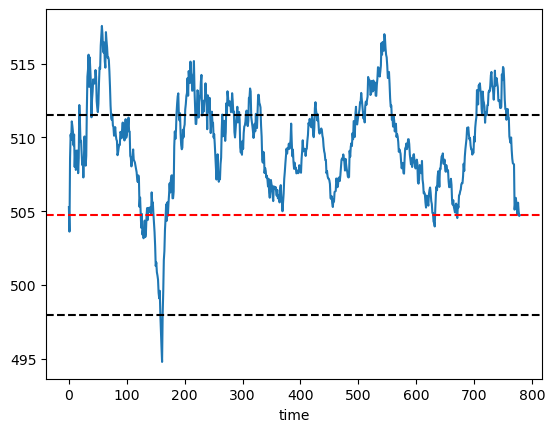

In [94]:
#df_all_days_stock['close'].plot(xlim=(300,400), ylim=(575,587))
df_all_days_stock['close'].plot()
plt.xlabel('time')
plt.axhline(y=y_value, color='r', linestyle='--', label=f'y = {y_value}')
plt.axhline(y=y_value_p, color='black', linestyle='--', label=f'y = {y_value_p}')
plt.axhline(y=y_value_m, color='black', linestyle='--', label=f'y = {y_value_m}')

In [ ]:
## checking right options

In [100]:
def get_option_chain(symbol):
    contract = Stock(symbol=symbol, exchange='SMART', currency='USD')
    ib.qualifyContracts(contract)
    chains = ib.reqSecDefOptParams(underlyingSymbol=contract.symbol, futFopExchange="", underlyingSecType=contract.secType, underlyingConId=contract.conId)
    chain = [ c for c in chains if c.exchange =='SMART'][0]
    return chain

In [101]:
def get_options_chain_for_expiry(symbol, expiry, min_strike=0, max_strike=np.Inf):
    option_chain = get_option_chain(symbol)
    options=[]
    for strike in option_chain.strikes:
        if strike <= max_strike and strike >= min_strike:
            for right in ['C', 'P']:
                option = Option(symbol=symbol, lastTradeDateOrContractMonth=expiry, strike=strike, right=right, exchange='SMART', currency='USD')
                options.append(option)
    valid_options=ib.qualifyContracts(*options)
    return valid_options

In [ ]:
### OPTION

In [102]:
contract = Contract(symbol='META', secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

[Contract(secType='STK', conId=107113386, symbol='META', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='META', tradingClass='NMS')]

In [103]:
print(entry)

[504.74]


Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.


In [ ]:
print(y_value_p, y_value_m) 

In [ ]:
valid_options = get_options_chain_for_expiry("META", "20250404", min_strike=500, max_strike=520)

In [ ]:
tickers_dict = {}
for option in valid_options:
    tickers_dict[(option.right, option.strike)] = ib.reqMktData(contract =option, genericTickList="", snapshot=False, regulatorySnapshot=False)

In [ ]:
ticker_call_to_sell_margin = tickers_dict['C', 520]
ticker_call_to_sell_margin.midpoint()

In [ ]:

ticker_call_to_sell = tickers_dict['C', 515]
ticker_call_to_sell.midpoint()

In [ ]:
ticker_put_to_sell = tickers_dict['P', 500]
ticker_put_to_sell.midpoint()

In [ ]:
ticker_put_to_sell_margin = tickers_dict['P', 500]
ticker_put_to_sell_margin.midpoint()

In [ ]:
print(f'current price({entry}')